<h2><font color="#004D7F" size=6>Árboles de decisión</font></h2>



<h1><font color="#004D7F" size=5> Clasificación y regresión</font></h1>

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

En esta sección, vamos a analizar el algoritmo base CART para árboles de decisión que puede aplicarse para resolver problemas de clasificación y de regresión. 
* El paquete y la función utilizados para entrenar y hacer predicciones.
* Las configuraciones en el paquete scikit-learn para el algoritmo, estos es, la configuración de sus hiperparámetros.

Al igual que los SVM, los árboles de decisión son algoritmos versátiles de aprendizaje automático que pueden realizar tanto tareas de clasificación como de regresión. Son algoritmos potentes, capaces de ajustarse a conjuntos de datos complejos. 
Los árboles de decisión son también los componentes fundamentales de los bosques aleatorios (Random Forest), que se encuentran entre los algoritmos de aprendizaje automático más potentes de la actualidad. 
Aquí  empezaremos por discutir cómo entrenar, visualizar y hacer predicciones con Árboles de Decisión. A continuación, repasaremos el algoritmo de entrenamiento CART utilizado por Scikit-Learn, y discutiremos cómo regularizar los árboles y utilizarlos para tareas de regresión. Por último, discutiremos algunas de las limitaciones de los árboles de decisión.

In [30]:
#  Se requiere de una versión Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Se requiere de una version Scikit-Learn ≥0.20 
import sklearn
assert sklearn.__version__ >= "0.20"

# Paquetes auxilicares comunes
import numpy as np
import os

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Costumizar el plot 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


---

<a id="section1"></a>
# <font color="#004D7F"> 2. Entrenamiento y visualización de un árbol de decisión</font>


Para entender los Árboles de Decisión, vamos a construir uno y a echar un vistazo a cómo realiza las predicciones. El siguiente código entrena un DecisionTreeClassifier en el conjunto de datos del iris.

In [68]:
from sklearn.datasets import load_iris # importamos la conocida base de datos Iris
from sklearn.tree import DecisionTreeClassifier, plot_tree # importamos la librería de sklearn
from sklearn.model_selection import train_test_split, cross_val_score
iris = load_iris()
X = iris.data[:, 2:] # tomamos las columna petal length y  width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

Puede visualizar el Árbol de Decisión:

[Text(133.92000000000002, 181.2, 'petal width (cm) <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(200.88000000000002, 108.72, 'petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

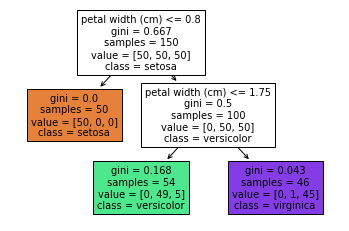

In [69]:
plot_tree(tree_clf, feature_names=iris.feature_names[2:],
class_names=iris.target_names, filled=True)

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Comentarios del árbol</font>

El atributo de ***samples*** de un nodo cuenta el número de instancias de entrenamiento a las que se aplica. Por ejemplo, 100 instancias de entrenamiento tienen una longitud de pétalo superior a 2,45 cm (profundidad 1, derecha), y de esas 100, 54 tienen una anchura de pétalo inferior a 1,75 cm (profundidad 2, izquierda). El atributo ***value*** de un nodo indica a cuántas instancias de entrenamiento de cada clase se aplica este nodo: por ejemplo, el nodo inferior derecho se aplica a 0 Iris setosa, 1 Iris versicolor y 45 Iris virginica. Por último, el atributo ***gini** de un nodo mide su impureza: un nodo es "puro" (gini=0) si todas las instancias de entrenamiento a las que se aplica pertenecen a la misma clase. Por ejemplo, como el nodo izquierdo de profundidad 1 sólo se aplica a los casos de entrenamiento de Iris setosa, es puro y su puntuación de gini es 0.

---

<a id="section1"></a>
# <font color="#004D7F"> 3. Realizar predicciones con el árbol</font>



Veamos cómo el árbol representado en la Figura anterior hace predicciones. Supongamos que encuentra una flor de iris y quiere clasificarla. Se empieza por el nodo raíz (profundidad 0, en la parte superior): este nodo pregunta si la longitud de los pétalos de la flor es inferior a 2,45 cm. Si lo es, entonces se desplaza hacia abajo hasta el nodo hijo izquierdo de la raíz (profundidad 1, izquierda). En este caso, es un nodo hoja (es decir, no tiene ningún nodo hijo), por lo que no hace ninguna pregunta: simplemente mira la clase predicha para ese nodo, y el Árbol de Decisión predice que su flor es una Iris setosa (clase=setosa).
Ahora suponga que encuentra otra flor, y que esta vez la longitud de los pétalos es superior a 2,45 cm. Debe bajar al nodo hijo derecho de la raíz (profundidad 1, derecha), que no es un nodo hoja, por lo que el nodo hace otra pregunta: ¿es la anchura del pétalo menor de 1,75 cm? Si es así, lo más probable es que su flor sea un Iris versicolor (profundidad 2, izquierda). Si no es así, es probable que sea un Iris virginica
(profundidad 2, derecha). 

Saving figure decision_tree_decision_boundaries_plot


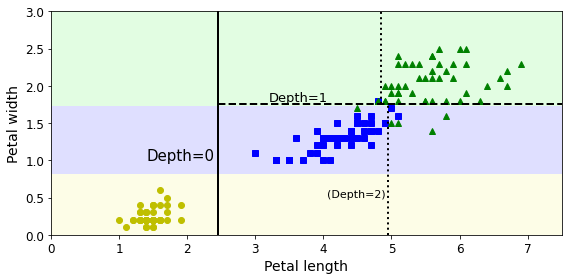

In [54]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

La Figura anterior muestra los límites de decisión de este árbol de decisión. La línea vertical gruesa representa el límite de decisión del nodo raíz (profundidad 0): longitud del pétalo = 2,45 cm. Como la zona de la izquierda es pura (sólo Iris setosa), no puede dividirse más. Sin embargo, la zona de la derecha es impura, por lo que el nodo derecho de profundidad 1 la divide a una anchura de pétalo = 1,75 cm (representada por la línea discontinua). Dado que la profundidad máxima se ha establecido en 2, el árbol de decisión se detiene justo ahí. Si se establece
profundidad máxima a 3, entonces los dos nodos de profundidad 2 añadirían cada uno otro límite de decisión
(representado por las líneas punteadas).

<a id="section3"></a>
# <font color="#004D7F"> 3. Estimando las probabilidades de clase </font>


Los árboles de decisión son intuitivos y sus decisiones son fáciles de interpretar. Este tipo de modelos suelen denominarse modelos de caja blanca. En cambio, como veremos, los Bosques Aleatorios o las redes neuronales se consideran generalmente modelos de caja negra. Hacen grandes predicciones, y se pueden comprobar fácilmente los cálculos que realizaron para hacer estas predicciones; sin embargo, suele ser difícil explicar en términos sencillos por qué se hicieron las predicciones. Por ejemplo, si una red neuronal dice que una persona concreta aparece en una foto, es difícil saber qué contribuyó a esta predicción: ¿el modelo reconoció los ojos de esa persona? ¿Su boca? ¿Su nariz? ¿Sus zapatos? ¿O incluso el sofá en el que estaba sentada? Por el contrario, los árboles de decisión proporcionan reglas de clasificación sencillas y agradables que pueden incluso aplicarse manualmente si es necesario (por ejemplo, para la clasificación de flores)

Un Árbol de Decisión también puede estimar la probabilidad de que una instancia pertenezca a una determinada clase k. Primero recorre el árbol para encontrar el nodo hoja de esta instancia, y luego devuelve la proporción de instancias de entrenamiento de la clase k en este nodo. Por ejemplo, supongamos que ha encontrado una flor cuyos pétalos miden 5 cm de largo y 1,5 cm de ancho. El nodo de hoja correspondiente es el nodo de profundidad 2 de la izquierda, por lo que el Árbol de Decisión debería arrojar las siguientes probabilidades 0% para Iris setosa (0/54), 90,7% para Iris versicolor (49/54) y 9,3% para Iris virginica (5/54). Y si se le pide que prediga la clase, debería dar como resultado Iris versicolor (clase 1) porque tiene la mayor probabilidad. Comprobemos esto:

In [55]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [56]:
tree_clf.predict([[5, 1.5]])

array([1])

<a id="section3"></a>
# <font color="#004D7F"> 3. Algoritmo CART </font>

Scikit-Learn utiliza el algoritmo de árbol de clasificación y regresión (CART) para entrenar árboles de decisión (también llamados árboles "crecientes"). El algoritmo funciona dividiendo primero el conjunto de entrenamiento en dos subconjuntos utilizando una única característica k y un umbral t (por ejemplo, "longitud de pétalo ≤ 2,45 cm"). ¿Cómo elige k y t? Busca el par (k, tk) que produce los subconjuntos más puros (ponderados por su tamaño). La ecuación 6-2 da la función de coste que el algoritmo intenta minimizar.



Una vez que el algoritmo CART ha dividido con éxito el conjunto de entrenamiento en dos, divide los subconjuntos utilizando la misma lógica, luego los sub-conjuntos, y así sucesivamente, de forma recursiva. El algoritmo deja de recursar una vez que alcanza la profundidad máxima (definida por el hiperparámetro max_depth), o si no puede encontrar una división que reduzca la impureza. Otros hiperparámetros (descritos más adelante) controlan otras condiciones de parada (min_samples_split, min_samples_leaf,
min_weight_fraction_leaf, y max_leaf_nodes).

Como puede ver, el algoritmo CART es un algoritmo codicioso: busca codiciosamente una división óptima en el nivel superior, y luego repite el proceso en cada nivel posterior. No comprueba si la división conducirá o no a la menor impureza posible varios niveles más abajo. Un algoritmo codicioso suele producir una solución razonablemente buena, pero no garantiza que sea óptima.
Desgraciadamente, se sabe que encontrar el árbol óptimo es un problema NP-Completo:2 requiere un tiempo O(exp(m)), lo que hace que el problema sea intratable incluso para conjuntos de entrenamiento pequeños. Por eso debemos conformarnos con una solución "razonablemente buena".

<a id="section31"></a>
## <font color="#004D7F"> 3.1. Regularización de los hiperparámetros del algoritmo CART</font>



Los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento (a diferencia de los modelos lineales, que asumen que los datos son lineales, por ejemplo). Si se deja sin restricciones, la estructura del árbol se adaptará a los datos de entrenamiento, ajustándose muy estrechamente a ellos; de hecho, lo más probable es que se sobreajuste. Este modelo suele denominarse no paramétrico, no porque no tenga parámetros (a menudo tiene muchos), sino porque el número de parámetros no se determina antes del entrenamiento, de modo que la estructura del modelo es libre de ajustarse a los datos. En cambio, un modelo paramétrico, como un modelo lineal, tiene un número predeterminado de parámetros, por lo que su grado de libertad es limitado, lo que reduce el riesgo de sobreajuste (pero aumenta el riesgo de subajuste).

En general, el principal problema de los árboles de decisión es que son muy sensibles a las pequeñas variaciones en los datos de entrenamiento. Por ejemplo, si sólo se elimina el Iris versicolor más ancho del conjunto de entrenamiento del iris (el que tiene pétalos de 4,8 cm de largo y 1,8 cm de ancho) y se entrena un nuevo Árbol de Decisión. En realidad, como el algoritmo de entrenamiento utilizado por Scikit-Learn es estocástico, puede obtener modelos muy diferentes incluso con los mismos datos de entrenamiento (a menos que configure el hiperparámetro random_state). Observe los resultados de la nueva división apenas modificando la semilla del árbol. 

Saving figure decision_tree_instability_plot


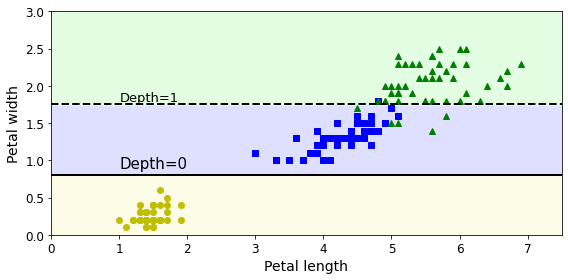

In [57]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()


Para evitar el sobreajuste de los datos de entrenamiento, es necesario restringir el grado de libertad del árbol de decisión durante el entrenamiento. Como ya sabe, esto se llama regularización. Los hiperparámetros de regularización dependen del algoritmo utilizado, pero generalmente se puede restringir al menos la profundidad máxima del Árbol de Decisión. En Scikit-Learn, esto se controla con el hiperparámetro max_depth (el valor por defecto es None, que significa ilimitado). La reducción de max_depth regularizará el modelo y, por tanto, reducirá el riesgo de sobreajuste.

La clase DecisionTreeClassifier tiene algunos otros parámetros que restringen de forma similar la forma del árbol de decisión: min_samples_split (el número mínimo de muestras que debe tener un nodo antes de poder dividirlo), min_samples_leaf (el número mínimo de muestras que debe tener un nodo hoja), min_weight_fraction_leaf (igual que min_samples_leaf pero expresado como una fracción del número total de instancias ponderadas), max_leaf_nodes (el número máximo de nodos hoja), y max_features (el número máximo de características que se evalúan para la división en cada nodo). Aumentar los hiperparámetros min_* o reducir los hiperparámetros max_* regularizará el modelo.

La Figura siguiente muestra dos Árboles de Decisión entrenados en el conjunto de datos de lunas (vea el codigo de SVM). A la izquierda, el Árbol de Decisión se entrena con los hiperparámetros por defecto (es decir, sin restricciones), y a la derecha se entrena con min_samples_leaf=4. Es bastante obvio que el modelo de la izquierda está sobreajustado, y el modelo de la derecha probablemente generalizará mejor.

Saving figure min_samples_leaf_plot


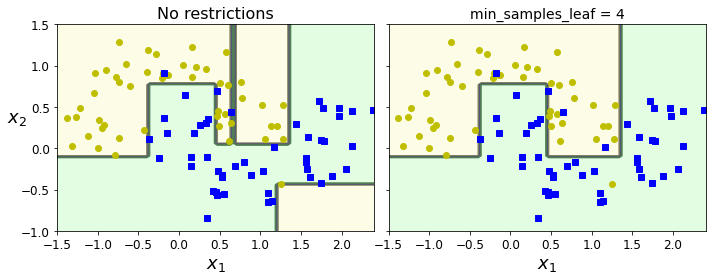

In [58]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

Los árboles de decisión tienen mucho a su favor: son sencillos de entender e interpretar, fáciles de usar, versátiles y potentes. Sin embargo, tienen algunas limitaciones. En primer lugar, como habrá notado, a los árboles de decisión les gustan los límites de decisión ortogonales (todas las divisiones son perpendiculares a un eje), lo que los hace sensibles a la rotación del conjunto de entrenamiento. Por ejemplo, la Figura siguiente  muestra un conjunto de datos simple y linealmente separable: a la izquierda, un Árbol de Decisión puede dividirlo fácilmente, mientras que a la derecha, después de girar el conjunto de datos 45°, el límite de decisión parece innecesariamente enrevesado. Aunque ambos árboles de decisión se ajustan perfectamente al conjunto de entrenamiento, es muy probable que el modelo de la derecha no generalice bien. Una forma de limitar este problema es utilizar el Análisis de Componentes Principales (PCA), que suele dar como resultado una mejor orientación de los datos de entrenamiento.

Saving figure sensitivity_to_rotation_plot


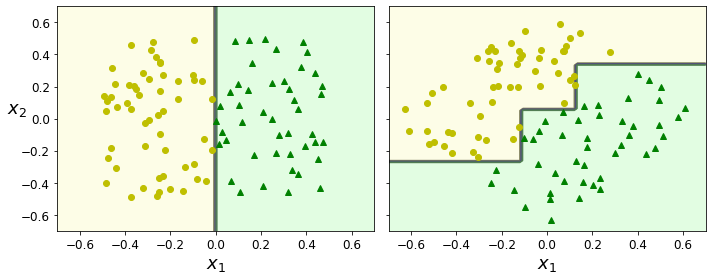

In [11]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

Osberve lo que sucede con la rotación en la base de datos de iris del primer ejemplo de este código

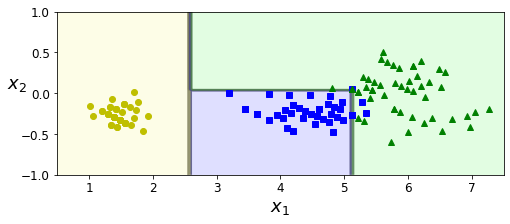

In [23]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

<a id="section2"></a>
# <font color="#004D7F"> 4. Regresión usando árboles de decisión</font>


Aquí preparammos una conjunto de datos cuadráticos para poder interpretar lo que sucede

In [85]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

Para general el árbol se utiliza la clase DecisionTreeRegressor 

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)
y_pred = tree_reg.predict(X)

[Text(167.4, 181.2, 'X[0] <= 0.197\nmse = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(83.7, 108.72, 'X[0] <= 0.092\nmse = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(41.85, 36.23999999999998, 'mse = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(251.10000000000002, 108.72, 'X[0] <= 0.772\nmse = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(209.25, 36.23999999999998, 'mse = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(292.95, 36.23999999999998, 'mse = 0.036\nsamples = 46\nvalue = 0.615')]

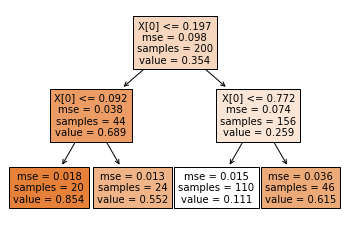

In [70]:
plot_tree(tree_reg, filled=True)

Este árbol se parece mucho al árbol de clasificación que construyó antes. La principal diferencia es que en lugar de predecir una clase en cada nodo, predice un valor. Por ejemplo, suponga que quiere hacer una predicción para una nueva instancia con x1 = 0,6. Recorre el árbol empezando por la raíz y acaba llegando al nodo hoja que predice el valor=0,111. Esta predicción es el valor objetivo medio de las 110 instancias de entrenamiento asociadas a este nodo hoja, y da lugar a un error cuadrático medio igual a 0,015 sobre estas 110 instancias. Las predicciones de este modelo se representan a la izquierda en la Figura siguiente.

Saving figure tree_regression_plot


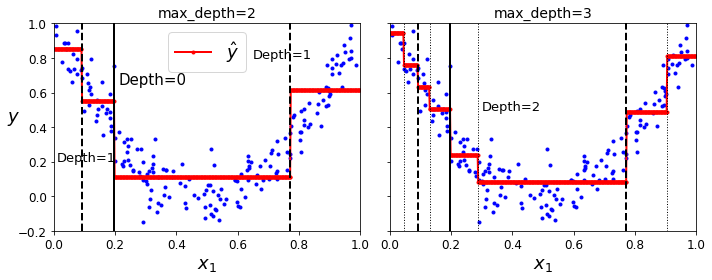

In [88]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

Si se establece max_depth=3, se obtienen las predicciones representadas a la derecha de la figura anterior. Observe cómo el valor predicho para cada región es siempre el valor objetivo medio de las instancias de esa región. El algoritmo divide cada región de forma que la mayoría de las instancias de entrenamiento se acerquen lo más posible a ese valor predicho.

[Text(279.0, 475.65000000000003, 'X[0] <= 0.197\nmse = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(139.5, 339.75, 'X[0] <= 0.092\nmse = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(69.75, 203.85000000000002, 'X[0] <= 0.046\nmse = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(34.875, 67.94999999999999, 'mse = 0.012\nsamples = 10\nvalue = 0.947'),
 Text(104.625, 67.94999999999999, 'mse = 0.006\nsamples = 10\nvalue = 0.761'),
 Text(209.25, 203.85000000000002, 'X[0] <= 0.13\nmse = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(174.375, 67.94999999999999, 'mse = 0.007\nsamples = 9\nvalue = 0.633'),
 Text(244.125, 67.94999999999999, 'mse = 0.01\nsamples = 15\nvalue = 0.504'),
 Text(418.5, 339.75, 'X[0] <= 0.772\nmse = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(348.75, 203.85000000000002, 'X[0] <= 0.287\nmse = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(313.875, 67.94999999999999, 'mse = 0.006\nsamples = 19\nvalue = 0.236'),
 Text(383.625, 67.94999999999999, 'mse = 0.013\nsamples = 91\nvalue = 

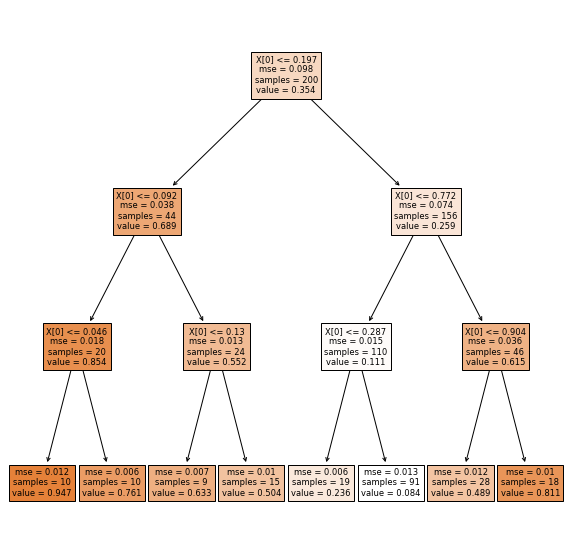

In [72]:
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(tree_reg2, filled=True)



El algoritmo CART funciona prácticamente igual que antes, excepto que en lugar de intentar dividir el conjunto de entrenamiento de forma que se minimice la impureza, ahora intenta dividir el conjunto de entrenamiento de forma que se minimice el MSE. La ecuación  XX muestra la función de coste que el algoritmo intenta minimizar.


Al igual que en las tareas de clasificación, los árboles de decisión son propensos a sobreajustarse cuando se trata de tareas de regresión. Sin ninguna regularización (es decir, utilizando los hiperparámetros por defecto), se obtienen las predicciones de la izquierda en la Figura a seguir. Estas predicciones obviamente se ajustan en exceso al conjunto de entrenamiento. Con sólo establecer min_samples_leaf=10 se obtiene un modelo mucho más razonable, representado en la derecha de la Figura.

Saving figure tree_regression_regularization_plot


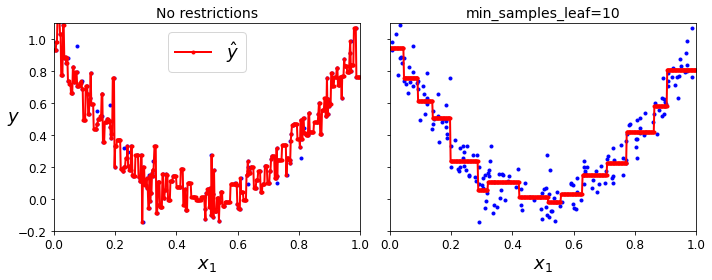

In [89]:

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# Exercise solutions

Classes: Nonowner, Owner


[Text(167.4, 163.07999999999998, 'Income <= 59.7\ngini = 0.5\nsamples = 24\nvalue = [12, 12]\nclass = Nonowner'),
 Text(83.7, 54.360000000000014, 'gini = 0.219\nsamples = 8\nvalue = [7, 1]\nclass = Nonowner'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.43\nsamples = 16\nvalue = [5, 11]\nclass = Owner')]

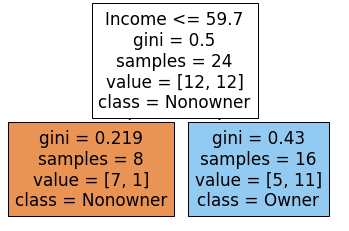

In [91]:
import pandas as pd
mower_df = pd.read_csv('RidingMowers.csv')
# use max_depth to control tree size (None = full tree)
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
print("Classes: {}".format(', '.join(classTree.classes_)))
plot_tree(classTree, feature_names=mower_df.columns[:2],
class_names=classTree.classes_, filled=True)


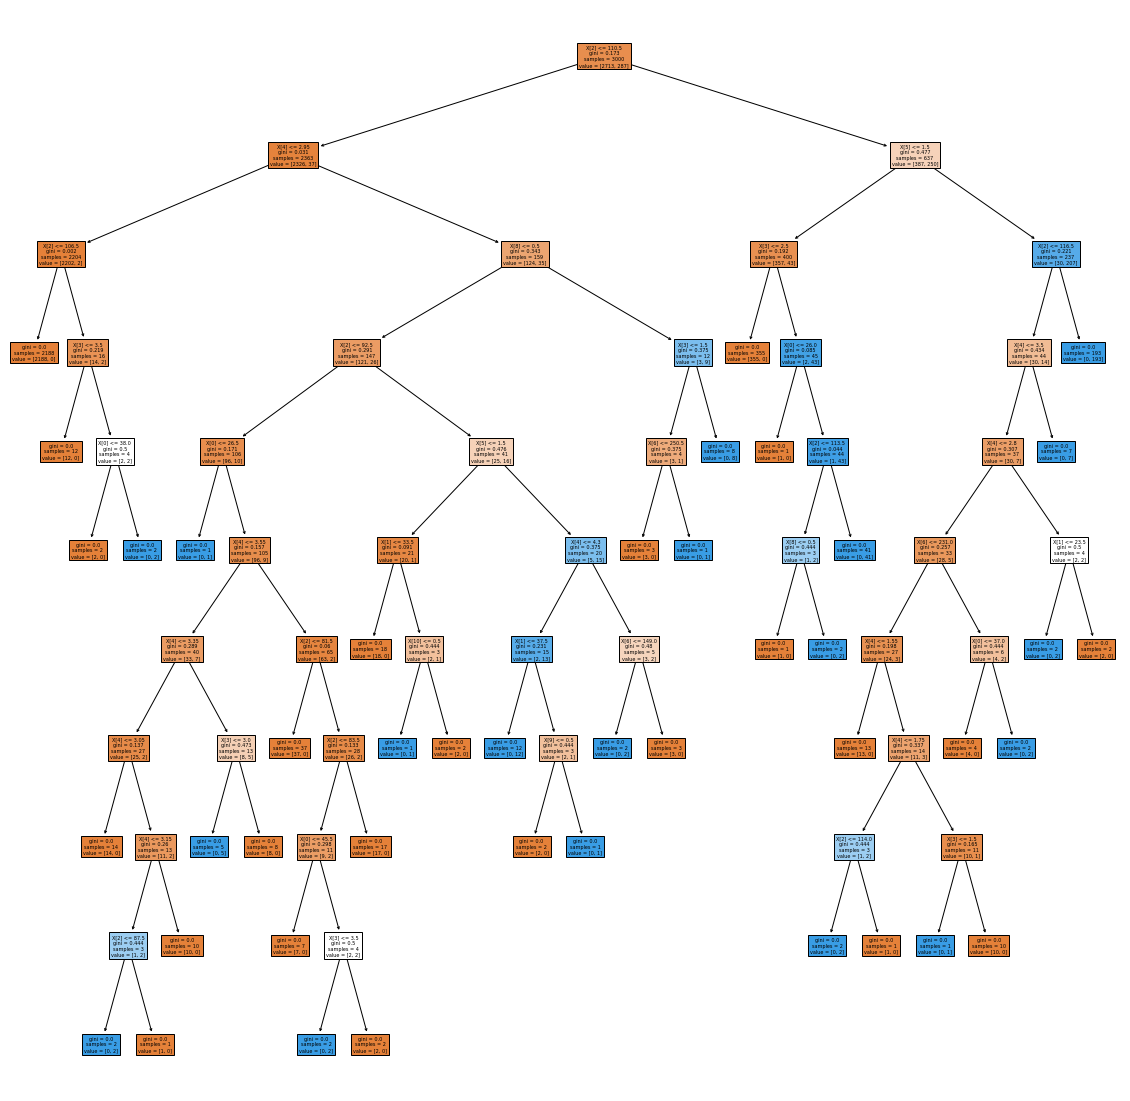

In [96]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_y)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20))
plot_tree(fullClassTree, filled=True);
fig.savefig('UniversalBank.png')


In [98]:
from sklearn.metrics import accuracy_score, classification_report
prevision = fullClassTree.predict(valid_X)
accuracy_score(valid_y, prevision)


0.979

In [100]:
!pip install yellowbrick
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(fullClassTree)
cm.fit(train_X, train_y)
cm.score(valid_X, valid_y)

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\a.tabaresp\\Anaconda3\\Lib\\site-packages\\~klearn\\datasets\\_svmlight_format_fast.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20,
min_impurity_decrease=0.01, random_state=1)
smallClassTree.fit(train_X, train_y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)